In [1]:
from minimal_model import ref_parameters,  I0, sensitivity_analysis, PARAMETER_NAMES, PARAMETER_DESCRIPTIONS
from minimal_model import perturbation_dynamics
import numpy as np

In [2]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from statannotations.Annotator import Annotator


# Set font size and style in matplotlib
plt.rcParams.update({'font.size': 12, 'font.family': 'Arial'})

# Error bar kwargs for prism style plots
errorbar_kwargs = {'capsize': 2, 'capthick': 1, 'elinewidth': 1, 'zorder': 10}

# Spine properties
spine_properties = {'color': 'black', 'linewidth': 2}

# TODO Better colors for this figure

# Color palate with basal, default, and perturbation colors
colors_basal = ['whitesmoke','lightsteelblue', 'steelblue']

# Color palate default, perturbation
colors_default = ['grey', 'indianred'] 



In [3]:
# Scaling 

# ATP per O2 (3 per O)
PO2 = 5.0
# Whole body oxygen consumption rate ~ 2000 nmol/min/gBW
vO2 = 2000 * 0.7 
# ATP production rate
vATP = PO2 * vO2 
# Scale the oxygen fluxes by vE
vE = vATP 


In [4]:
KI_F = 0.2
p_fited = ref_parameters( KI_F = KI_F)

In [5]:
# compute sensitivity indices 

SENS_PARAMS = ["vE", "Imax", "C", "KI_lipo", "KA_glut4", "KF", "KG", "omega", 
               "lam", "gamma", "beta", "kappa", "alpha", "VR", "VFK", "KFK",
                "VLG", "KL", "KI_F", "v0", ]


results_healthy = dict()
results_obese = dict()
for p in SENS_PARAMS:
    S_0 = sensitivity_analysis(p,1.0, p_fited,)
    S_10 = sensitivity_analysis(p,10.0, p_fited,)

    results_healthy[p] = S_0
    results_obese[p] = S_10


df_healthy = pd.DataFrame(results_healthy).T
df_obese = pd.DataFrame(results_obese).T

# Drop the last colums - they fluxes that are 0 by definition
df_healthy = df_healthy.drop(columns=["v_in_L","v_in_G","v_in_F","v_in_K","vI"], axis=1)
df_obese = df_obese.drop(columns=["v_in_L","v_in_G","v_in_F","v_in_K","vI"], axis=1)

# Add a condition column
df_healthy["Condition"] = "Healthy"
df_obese["Condition"] = "Obese"

df = pd.concat([df_healthy, df_obese])
df.reset_index(inplace=True)
df = df.rename(columns={"index": "Parameter"})

# Map the parameter names to the descriptions
df["ParameterDescription"] = df["Parameter"].map(PARAMETER_DESCRIPTIONS)

# K parameters are 1/K in the model so multiply by -1 for clarity
# If parameter description contains "Affinity" multiply by -1
# Get numierical columns
num_col = df.select_dtypes(include=[np.number]).columns
df.loc[df["ParameterDescription"].str.contains("affinity"), num_col] *= -1
df.loc[df["ParameterDescription"].str.contains("inhibition"), num_col] *= -1
df.loc[df["ParameterDescription"].str.contains("activation"), num_col] *= -1



/Users/dw6835/src/competitive_catabolism/minimal_model/minimal_model.py:579: RuntimeWarning: invalid value encountered in true_divide
  dX = np.log(X_1/X0) / np.log(fold_change)
/Users/dw6835/src/competitive_catabolism/minimal_model/minimal_model.py:580: RuntimeWarning: invalid value encountered in true_divide
  dF = np.log(F_1/F0) / np.log(fold_change)
/Users/dw6835/src/competitive_catabolism/minimal_model/minimal_model.py:579: RuntimeWarning: invalid value encountered in true_divide
  dX = np.log(X_1/X0) / np.log(fold_change)
/Users/dw6835/src/competitive_catabolism/minimal_model/minimal_model.py:580: RuntimeWarning: invalid value encountered in true_divide
  dF = np.log(F_1/F0) / np.log(fold_change)
/Users/dw6835/src/competitive_catabolism/minimal_model/minimal_model.py:579: RuntimeWarning: invalid value encountered in true_divide
  dX = np.log(X_1/X0) / np.log(fold_change)
/Users/dw6835/src/competitive_catabolism/minimal_model/minimal_model.py:580: RuntimeWarning: invalid value enc

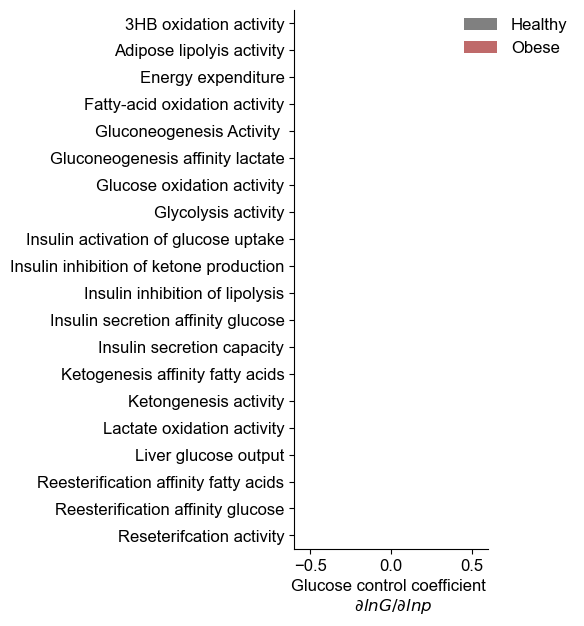

In [6]:
# Make a bar graph of the glucose sensitivity indices
fig, ax = plt.subplots(1, 1, figsize=(2.5, 7),)

# Order by the glucose sensitivity
order = df.groupby("ParameterDescription")["G"].mean().sort_values().index

sns.barplot(data=df, y="ParameterDescription" ,x='G', ax=ax, hue='Condition', palette=colors_default, order=order)
plt.xlim(-0.6, 0.6)

sns.despine()
ax.set_xlabel("Glucose control coefficient \n $\\partial ln G / \\partial ln p$")
ax.set_ylabel("")

# Put the legend outside the plot
ax.legend(loc='center left', bbox_to_anchor=(0.8, 0.95,) , frameon=False)    

# Save the figure
plt.savefig("output/sensitivity_glucose.svg", bbox_inches='tight')

In [7]:
# Make line plots for modifying pertubing individual parameters vE, Imax and VR
time = np.linspace(0, 500, 10)


# vE 
perturbations = np.linspace(0.5, 2, 100)

# Compute the line for healthy and obese 
vE0 = p_fited[PARAMETER_NAMES.index("vE")]
pertubation_vE_healthy = pd.DataFrame([ perturbation_dynamics(time,1.0, p= p_fited, vE=vE0 * r )[0].iloc[-1] for r in perturbations],  index=perturbations)
pertubation_vE_obese = pd.DataFrame([ perturbation_dynamics(time,10.0, p= p_fited, vE=vE0 * r )[0].iloc[-1] for r in perturbations],  index=perturbations)  

# Imax 
perturbations = np.linspace(0.1, 2, 100)
Imax0 = p_fited[PARAMETER_NAMES.index("Imax")]
pertubation_Imax_healthy = pd.DataFrame([ perturbation_dynamics(time,1.0, p= p_fited, Imax=Imax0 * r )[0].iloc[-1] for r in perturbations],  index=perturbations)
pertubation_Imax_obese = pd.DataFrame([ perturbation_dynamics(time,10.0, p= p_fited, Imax=Imax0 * r )[0].iloc[-1] for r in perturbations],  index=perturbations)

# VR
perturbations = np.linspace(0.1, 10, 100)
VR0 = p_fited[PARAMETER_NAMES.index("VR")]
pertubation_VR_healthy = pd.DataFrame([ perturbation_dynamics(time,1.0, p= p_fited, VR=VR0 * r )[0].iloc[-1] for r in perturbations],  index=perturbations)
pertubation_VR_obese = pd.DataFrame([ perturbation_dynamics(time,10.0, p= p_fited, VR=VR0 * r )[0].iloc[-1] for r in perturbations],  index=perturbations)

# KF
perturbations = np.linspace(0.1, 10, 100)
KF0 = p_fited[PARAMETER_NAMES.index("KF")]
pertubation_KF_healthy = pd.DataFrame([ perturbation_dynamics(time,1.0, p= p_fited, KF=KF0 * r )[0].iloc[-1] for r in perturbations],  index=perturbations)
pertubation_KF_obese = pd.DataFrame([ perturbation_dynamics(time,10.0, p= p_fited, KF=KF0 * r )[0].iloc[-1] for r in perturbations],  index=perturbations)


# beta oxidation effect
perturbations = np.linspace(0.1, 5, 100)
beta = p_fited[PARAMETER_NAMES.index("beta")]
pertubation_beta_healthy = pd.DataFrame([ perturbation_dynamics(time,1.0, p= p_fited, beta=beta * r )[0].iloc[-1] for r in perturbations],  index=perturbations)
pertubation_beta_obese = pd.DataFrame([ perturbation_dynamics(time,10.0, p= p_fited, beta=beta * r )[0].iloc[-1] for r in perturbations],  index=perturbations)


# Liver glucose output effect
perturbations = np.linspace(0.5, 2, 100)
v0 = p_fited[PARAMETER_NAMES.index("v0")]
pertubation_v0_healthy = pd.DataFrame([ perturbation_dynamics(time,1.0, p= p_fited, v0=v0 * r )[0].iloc[-1] for r in perturbations],  index=perturbations)
pertubation_v0_obese = pd.DataFrame([ perturbation_dynamics(time,10.0, p= p_fited, v0=v0 * r )[0].iloc[-1] for r in perturbations],  index=perturbations)



dataframes = [pertubation_vE_healthy, pertubation_vE_obese, 
              pertubation_Imax_healthy, pertubation_Imax_obese, 
              pertubation_VR_healthy, pertubation_VR_obese,
              pertubation_v0_healthy, pertubation_v0_obese,
              pertubation_beta_healthy, pertubation_beta_obese]


# Scale concentration to the respecrive basal values
for df in dataframes:
    df['G'] = df['G'] * 100 # 100 mg/dL
    df['I'] = df['I']/I0 * 0.4 # 0.4 ng/mL
    df['F'] = df['F'] * 0.5 # mM
    df['K'] = df['K'] * 0.5 # mM
    df['L'] = df['L'] * 0.7 # mM

    df['HOMA-IR'] = df['G'] * df['I'] / 5808 * 1e6 / 405


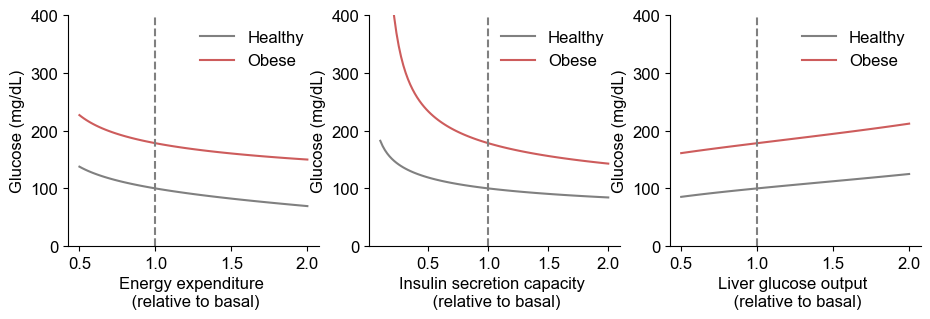

In [8]:
# Plot 
fig, ax = plt.subplots(1, 3, figsize=(11, 3),)

# Compute 
ax[0].plot(pertubation_vE_healthy.index, pertubation_vE_healthy["G"], color=colors_default[0], label="Healthy")
ax[0].plot(pertubation_vE_obese.index, pertubation_vE_obese["G"], color=colors_default[1], label="Obese")
ax[0].set_xlabel("Energy expenditure \n (relative to basal)")
ax[0].set_ylabel("Glucose (mg/dL)")
ax[0].axvline(1, color='grey', linestyle='--')


ax[1].plot(pertubation_Imax_healthy.index, pertubation_Imax_healthy["G"], color=colors_default[0], label="Healthy")
ax[1].plot(pertubation_Imax_obese.index, pertubation_Imax_obese["G"], color=colors_default[1], label="Obese")
ax[1].set_xlabel("Insulin secretion capacity \n (relative to basal)")
ax[1].axvline(1, color='grey', linestyle='--')
ax[1].set_ylabel("Glucose (mg/dL)")


ax[2].plot(pertubation_v0_healthy.index, pertubation_v0_healthy["G"], color=colors_default[0], label="Healthy")
ax[2].plot(pertubation_v0_obese.index, pertubation_v0_obese["G"], color=colors_default[1], label="Obese")
# dashed line at 1 
ax[2].axvline(1, color='grey', linestyle='--')
ax[2].set_ylabel("Glucose (mg/dL)")

ax[2].set_xlabel("Liver glucose output \n (relative to basal)")

# Set y-lables to 0 ,400 
for a in ax:
    a.set_ylim(0, 400)

    a.legend(frameon=False) 


sns.despine()
plt.savefig("output/glucose_sensitivity_major_effects_trivial.svg", bbox_inches='tight')

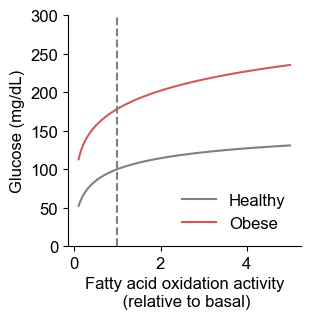

In [9]:
# Plot Beta oixdations effects 
fig, ax = plt.subplots(1, 1, figsize=(3, 3),)

ax.plot(pertubation_beta_healthy.index, pertubation_beta_healthy["G"], color=colors_default[0], label="Healthy")
ax.plot(pertubation_beta_obese.index, pertubation_beta_obese["G"], color=colors_default[1], label="Obese")

ax.set_xlabel("Fatty acid oxidation activity\n (relative to basal)")
ax.set_ylabel("Glucose (mg/dL)")
ax.axvline(1, color='grey', linestyle='--')

ax.legend(frameon=False)

ax.set_ylim(0, 300)


sns.despine()
plt.savefig("output/glucose_sensitivity_beta_oxidation.svg", bbox_inches='tight')

In [10]:
colors_default = ['black', 'grey']

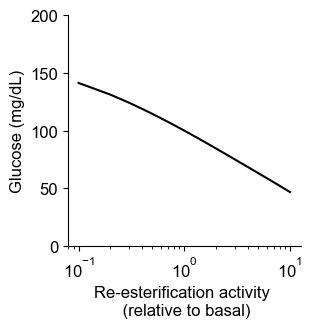

In [11]:
# Plot VR effects
fig, ax = plt.subplots(1, 1, figsize=(3, 3),)

ax.plot(pertubation_VR_healthy.index, pertubation_VR_healthy["G"], color=colors_default[0], label="Lean")
#ax.plot(pertubation_VR_obese.index, pertubation_VR_obese["G"], color=colors_default[1], label="Obese")

ax.set_xlabel("Re-esterification activity \n (relative to basal)")
ax.set_ylabel("Glucose (mg/dL)")
#ax.legend(frameon=False)

ax.set_ylim(0, 200)
ax.set_xscale('log')
sns.despine()

plt.savefig("output/sensitivity_glucose_reesterification.svg", bbox_inches='tight')

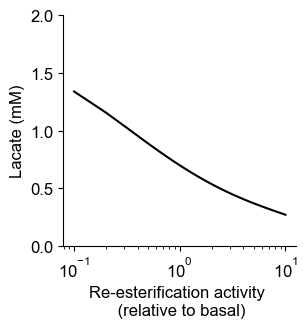

In [12]:
# Plot VR effects
fig, ax = plt.subplots(1, 1, figsize=(3, 3),)

ax.plot(pertubation_VR_healthy.index, pertubation_VR_healthy["L"], color=colors_default[0], label="Lean")
#ax.plot(pertubation_VR_obese.index, pertubation_VR_obese["L"], color=colors_default[1], label="Obese")

ax.set_xlabel("Re-esterification activity \n (relative to basal)")
ax.set_ylabel("Lacate (mM)")
#ax.legend(frameon=False)

ax.set_ylim(0,2)
ax.set_xscale('log')
sns.despine()

plt.savefig("output/sensitivity_lactate_reesterification.svg", bbox_inches='tight')

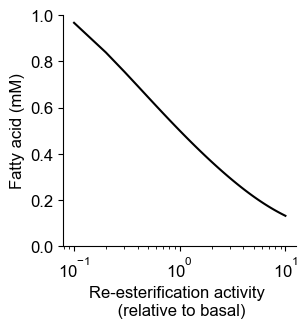

In [13]:
# Plot VR effects
fig, ax = plt.subplots(1, 1, figsize=(3, 3),)

ax.plot(pertubation_VR_healthy.index, pertubation_VR_healthy["F"], color=colors_default[0], label="Lean")
#ax.plot(pertubation_VR_obese.index, pertubation_VR_obese["F"], color=colors_default[1], label="Obese")

ax.set_xlabel("Re-esterification activity \n (relative to basal)")
ax.set_ylabel("Fatty acid (mM)")
#ax.legend(frameon=False)

ax.set_ylim(0, 1)
ax.set_xscale('log')
sns.despine()

plt.savefig("output/sensitivity_ffa_reesterification.svg", bbox_inches='tight')

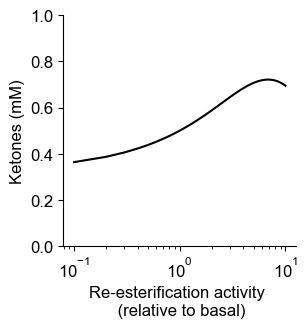

In [14]:
# Plot VR effects
fig, ax = plt.subplots(1, 1, figsize=(3, 3),)

ax.plot(pertubation_VR_healthy.index, pertubation_VR_healthy["K"], color=colors_default[0], label="Lean")
#ax.plot(pertubation_VR_obese.index, pertubation_VR_obese["K"], color=colors_default[1], label="Obese")

ax.set_xlabel("Re-esterification activity \n (relative to basal)")
ax.set_ylabel("Ketones (mM)")
#ax.legend(frameon=False)

ax.set_ylim(0, 1)
ax.set_xscale('log')

sns.despine()

plt.savefig("output/sensitivity_ketones_reesterification.svg", bbox_inches='tight')

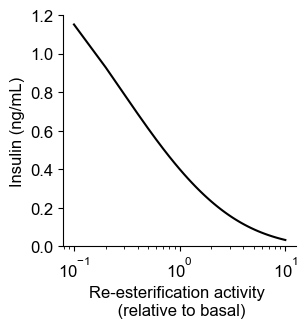

In [15]:
# Plot VR effects
fig, ax = plt.subplots(1, 1, figsize=(3, 3),)

ax.plot(pertubation_VR_healthy.index, pertubation_VR_healthy["I"], color=colors_default[0], label="Lean")
#ax.plot(pertubation_VR_obese.index, pertubation_VR_obese["I"], color=colors_default[1], label="Obese")

ax.set_xlabel("Re-esterification activity \n (relative to basal)")
ax.set_ylabel("Insulin (ng/mL)")
#ax.legend(frameon=False)

ax.set_ylim(0, 1.2)
ax.set_xscale('log')

sns.despine()

plt.savefig("output/sensitivity_insulin_reesterification.svg", bbox_inches='tight')

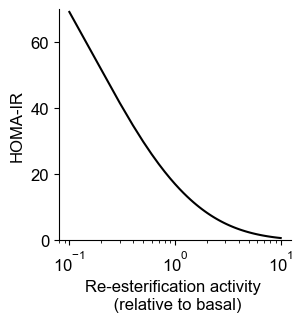

In [17]:
# Plot VR effects
fig, ax = plt.subplots(1, 1, figsize=(3, 3),)

ax.plot(pertubation_VR_healthy.index, pertubation_VR_healthy["HOMA-IR"], color=colors_default[0], label="Lean")
#ax.plot(pertubation_VR_obese.index, pertubation_VR_obese["I"], color=colors_default[1], label="Obese")

ax.set_xlabel("Re-esterification activity \n (relative to basal)")
ax.set_ylabel("HOMA-IR")
#ax.legend(frameon=False)

ax.set_ylim(0, 70)
ax.set_xscale('log')

sns.despine()

plt.savefig("output/sensitivity_HOMA_IR_reesterification.svg", bbox_inches='tight')